In [65]:
import os
import urllib, cStringIO

import pymongo as pm

from IPython.display import clear_output

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import json
import analysis_helpers as h

### load in model param posterior (bdaOutput/**splitbyobjectParams.csv)

In [214]:
## define set of models to compare
model_prefixes = ['human_full25k','sketch_avg_full25k','sketch_unroll_full25k']
all_param_paths = sorted(os.listdir('../models/bdaOutput'))
model_zoo = [i for i in all_param_paths for pre in model_prefixes if pre in i]
model_zoo = [i for i in model_zoo if i[-1] != '~']
assert len(model_zoo) == 18

In [215]:
import analysis_helpers as h
reload(h)

LL = []
model_name = []
for this_model in model_zoo:

    ## define paths to model predictions
    path_to_evaluate = '../models/evaluateOutput'
    if this_model.split('_')[0]=='sketch':
        model_dirname = ('_').join(this_model.split('_')[:5])
    else:
        model_dirname = ('_').join(this_model.split('_')[:4])
    pred_path = os.path.join(path_to_evaluate,model_dirname)

    ## get file with params from this model
    this_params = os.path.join('../models/bdaOutput',this_model)
    params = pd.read_csv(this_params)
    assert np.round(np.sum(np.exp(params.posteriorProb.values)),12)==1
    ## append MAP LL
    LL.append(params.sort_values(by=['logLikelihood'],ascending=False).iloc[0]['logLikelihood'])
    model_name.append(model_dirname)

In [218]:
PP = pd.DataFrame.from_records(zip(model_name,LL))
PP.columns=['model','MAP LL']
PP

,model,MAP LL
0,human_full25k_S0_cost,-2466.286167
1,human_full25k_S0_nocost,-2477.907423
2,human_full25k_S1_cost,-2349.261145
3,human_full25k_S1_nocost,-2351.422788
4,human_full25k_combined_cost,-2341.915029
5,human_full25k_combined_nocost,-2344.332791
6,sketch_avg_full25k_S0_cost,-2836.211896
7,sketch_avg_full25k_S0_nocost,-2837.680703
8,sketch_avg_full25k_S1_cost,-2724.930818
9,sketch_avg_full25k_S1_nocost,-2725.427277


In [ ]:
import analysis_helpers as h
reload(h)

for this_model in model_zoo:

    ## define paths to model predictions
    path_to_evaluate = '../models/evaluateOutput'
    model_dirname = ('_').join(this_model.split('_')[:4])
    pred_path = os.path.join(path_to_evaluate,model_dirname)

    ## get file with params from this model
    this_params = os.path.join('../models/bdaOutput',this_model)
    params = pd.read_csv(this_params)
    assert np.round(np.sum(np.exp(params.posteriorProb.values)),12)==1

    ## get list of all predictives (accepted MCMC samples)
    pred_files = [i for i in os.listdir(pred_path) if i[-15:] =='Predictives.csv']
    h.sort_filelist(pred_files) ## sort pred_files into human ordering

    X = [] ## initialize giant dataframe that contains predictions from all MCMC samples

    ## loop through MCMC samples
    for i,this_sample in enumerate(pred_files):
        print 'Currently evaluating {}'.format(model_dirname)
        print'{} | sample ID: {} '.format(i,int(this_sample.split('Predictives.csv')[0]))
        ## read in predictions from this sample
        sample_path = os.path.join(pred_path,this_sample)
        sample_preds = pd.read_csv(sample_path)
        sample_ind = int(this_sample.split('Predictives.csv')[0]) ## index of MCMC sample
        clear_output(wait=True)

        #### get params that generated these predictions
        #alpha = params.iloc[sample_ind]['alpha']
        #simScaling = params.iloc[sample_ind]['simScaling']
        #pragWeight = params.iloc[sample_ind]['pragWeight']
        #costWeight = params.iloc[sample_ind]['costWeight']
        posteriorProb = params.iloc[sample_ind]['posteriorProb']
        #logLikelihood = params.iloc[sample_ind]['logLikelihood']

        ## get congruent/incongruent context log odds for each sketch
        sketches = np.unique(sample_preds['trueSketch'].values)
        log_odds = []
        label = []
        condition = []
        for this_sketch in sketches:
            sketch_inds = sample_preds['trueSketch']==this_sketch
            these_rows = sample_preds[sketch_inds]
            cond = np.unique(these_rows['condition'].values)[0]
            other_cond = [i for i in ['closer','further'] if i != cond][0]
            obj = these_rows.iloc[0]['Target'].split('_')[-1]
            congruent_prob = these_rows[these_rows['coarseGrainedPossibleSketch']=='{}_{}'.format(cond,obj)]['modelProb'].values[0]
            other_prob = these_rows[these_rows['coarseGrainedPossibleSketch']=='{}_{}'.format(other_cond,obj)]['modelProb'].values[0]
            log_odds.append(congruent_prob - other_prob)
            label.append(obj)
            condition.append(cond)  

        ## make dataframe out of this sample
        sampleProb = [posteriorProb]*len(condition)
        sampleInd = [sample_ind]*len(condition)
        x = pd.DataFrame([sampleInd,sampleProb,condition,label,list(sketches),log_odds])
        x = x.transpose()
        x.columns = ['sample_ind','sample_prob','condition','label','sketch','odds']
        x = x.sort_values(by=['condition','label','sketch'])   

        ## concatenate dataframes containing log-odds from all MCMC samples
        if len(X)==0:
            X = x
        else:
            X = pd.concat([X,x])

    # save out            
    X.odds = X.odds.astype('float')
    X.sample_prob = X.sample_prob.astype('float')
    print 'Saving out model predictions for {}'.format(model_dirname)
    X.to_csv('{}_model_predictions_log_odds.csv'.format(model_dirname))            

Currently evaluating human_full25k_S0_nocost
154 | sample ID: 154 


In [72]:
pp = X.groupby(['sample_ind'])['sample_prob'].mean().apply(lambda x: np.exp(x)) ## posterior probs
lo = X.groupby(['sample_ind'])['odds'].mean() ## log odds
odds_overall = np.sum(pp*lo)
print '{} log odds in favor of picking sketch from congruent-context'.format(odds_overall)

0.190543137206 log odds in favor of picking sketch from congruent-context


In [73]:
weighted_odds = []
unweighted_odds = []
for i,sketch in enumerate(sketches):
    print '{} {}'.format(i,sketch)
    Y = X[X['sketch']==sketch]
    product = Y.apply(lambda x: x['odds'] * np.exp(x['sample_prob']), axis=1)
    weighted_odds.append(np.sum(product))
    unweighted_odds.append(Y['odds'].mean())
    clear_output(wait=True)


536 fea038f4c9b8_9


In [78]:
odds_files = [i for i in os.listdir(os.getcwd()) if '_log_odds.csv' in i]

In [81]:
for odd in odds_files:
    Z = pd.read_csv(odd)
    pp = Z.groupby(['sample_ind'])['sample_prob'].mean().apply(lambda x: np.exp(x)) ## posterior probs
    lo = Z.groupby(['sample_ind'])['odds'].mean() ## log odds
    odds_overall = np.sum(pp*lo)
    print odd
    print '{} log odds in favor of picking sketch from congruent-context'.format(odds_overall)    
    

human_full25k_S1_nocost_model_predictions_log_odds.csv
0.1958156126 log odds in favor of picking sketch from congruent-context
fc6_combined_cost_model_predictions_log_odds.csv
0.0481207532728 log odds in favor of picking sketch from congruent-context
human_full25k_combined_cost_model_predictions_log_odds.csv
0.216662949181 log odds in favor of picking sketch from congruent-context
human_full25k_S1_cost_model_predictions_log_odds.csv
0.213898221543 log odds in favor of picking sketch from congruent-context
human_full25k_combined_nocost_model_predictions_log_odds.csv
0.190543137206 log odds in favor of picking sketch from congruent-context
human_full25k_S0_cost_model_predictions_log_odds.csv
0.199894888702 log odds in favor of picking sketch from congruent-context
human_full25k_S0_nocost_model_predictions_log_odds.csv
0.180512981228 log odds in favor of picking sketch from congruent-context


In [85]:
params.head()

,id,perception,pragmatics,production,simScaling,pragWeight,costWeight,infWeight,logLikelihood,posteriorProb
0,0,sketch_avg_full25k,S0,cost,1,0,1.057553,7.920750,-2839.225666,-6.907755
1,1,sketch_avg_full25k,S0,cost,1,0,1.057553,7.973481,-2839.731495,-6.907755
2,2,sketch_avg_full25k,S0,cost,1,0,1.057553,7.905505,-2839.091641,-6.907755
3,3,sketch_avg_full25k,S0,cost,1,0,0.990464,7.905505,-2838.842320,-6.907755
4,4,sketch_avg_full25k,S0,cost,1,0,1.033421,7.905505,-2838.997192,-6.907755


In [158]:
np.exp(params['posteriorProb'])*1000

In [170]:
def gen_samples_from_posterior(params,nSamples=1000):
    duples = np.exp(params['posteriorProb'])*nSamples.values
    S = []
    for i,d in params.iterrows():
        _s = d      

In [96]:
def sumlogprob(a,b):
    if (a > b):
        return a + np.log1p(np.exp(b-a))
    else:
        return b + np.log1p(np.exp(a-b))  

In [151]:
PP = params.groupby('logLikelihood')['logLikelihood'].\
apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))

In [171]:
this_params = os.path.join('../models/bdaOutput',model_zoo[4])
params = pd.read_csv(this_params)
print this_params
params.head()

../models/bdaOutput/human_full25k_combined_cost_splitbyobjectParams.csv


,id,perception,pragmatics,production,simScaling,pragWeight,costWeight,infWeight,logLikelihood,posteriorProb
0,0,human_full25k,combined,cost,11.135331,0.103684,4.657400,7.359281,-2497.545380,-6.907755
1,1,human_full25k,combined,cost,11.135331,0.101625,4.657400,7.359281,-2497.685102,-6.907755
2,2,human_full25k,combined,cost,11.135331,0.101625,4.615136,7.359281,-2496.987912,-5.809143
3,3,human_full25k,combined,cost,11.135331,0.101625,4.685571,7.359281,-2498.155587,-6.907755
4,4,human_full25k,combined,cost,11.135331,0.101625,4.598153,7.359281,-2496.710694,-6.907755


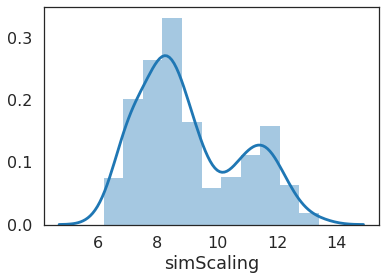

In [172]:
h = sns.distplot(params['simScaling'])

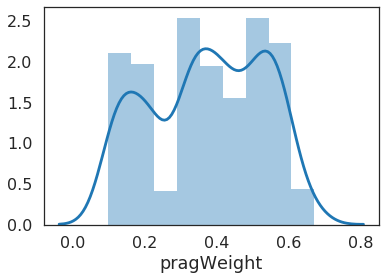

In [173]:
h = sns.distplot(params['pragWeight'])

4.685570931635403


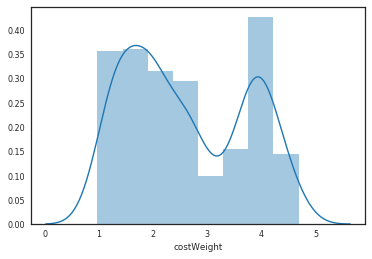

In [177]:
sns.set_context('paper')
h = sns.distplot(params['costWeight'])
print max(params['costWeight'])

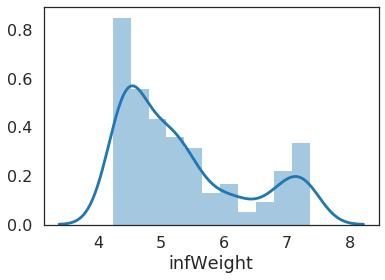

In [175]:
h = sns.distplot(params['infWeight'])
p